<a href="https://colab.research.google.com/github/ua-datalab/Geospatial_Workshops/blob/main/notebooks/zarr_xarray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ua-datalab/Geospatial_Workshops/blob/main/notebooks/zarr_xarray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gridded Daily Meteorological Data Analysis

Gridded estimates of daily weather parameters. [ORNL Daymet](https://daymet.ornl.gov/) Version 4 variables include the following parameters: minimum temperature, maximum temperature, precipitation, shortwave radiation, vapor pressure, snow water equivalent, and day length.

[Daymet]((https://daymet.ornl.gov/)) provides measurements of near-surface meteorological conditions; the main purpose is to provide data estimates where no instrumentation exists. The dataset covers the period from January 1, 1980 to the present. Each year is processed individually at the close of a calendar year. Data are in a [Lambert conformal conic projection](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) for North America and are distributed in [Zarr](https://zarr.readthedocs.io/en/stable/) and [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) formats, compliant with the [Climate and Forecast (CF) metadata conventions](http://cfconventions.org) (version 1.6).

This example loads Daymet data that are stored in [Zarr format](https://zarr.readthedocs.io/en/stable/) into an [xarray](https://docs.xarray.dev/en/stable/getting-started-guide/why-xarray.html) Dataset. Daymet provides gridded weather data for North America. We'll look at [daily frequency data covering North America](https://planetarycomputer.microsoft.com/dataset/daymet-daily-na).

The [STAC Collections](https://stacindex.org/catalogs/microsoft-pc#/) provided by the [Planetary Computer](https://planetarycomputer.microsoft.com/) contain assets with links to the root of the [Zarr store](https://planetarycomputer.microsoft.com/dataset/daymet-daily-na).



For this example we need to install the following Python packages:
* `pystac_client` for searching the [STAC](https://stacindex.org/) [- Index](https://stacspec.org/en/) for [COG](https://www.cogeo.org/) files.
* [`fsspec`](https://filesystem-spec.readthedocs.io/en/latest/) for connecting with remote filesystems.

And use the following standard Python libraries: `xarray` for handling multidimensional data and `matplotlib` for doing graphics.


In [1]:
# Install tornado>=6.2
!pip install tornado==6.3.2


In [2]:
# Install a complete version of xarray
!pip install xarray[complete] --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 40.6 MB/s eta 0:00:00


In [3]:
# Install pystac_client
!pip install pystac_client --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 5.6 MB/s eta 0:00:00


In [4]:
# Install fsspec
!pip install fsspec --quiet


In [6]:
# Install cfgrib
#!pip install cfgrib


In [7]:
# Install ecCodes library
#!pip install eccodes


In [8]:
!pip install dask-gateway --quiet


In [9]:
!pip install Cartopy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 12.9 MB/s eta 0:00:00


## Next, we proceed to load all the required libraries


In [5]:
import warnings
import pystac
import fsspec
#import eccodes
#import cfgrib
import cartopy

import xarray as xr
import matplotlib.pyplot as plt

from dask_gateway import GatewayCluster


warnings.simplefilter("ignore", RuntimeWarning)


The STAC browser for Daymet monthly is https://radiantearth.github.io/stac-browser/#/external/planetarycomputer.microsoft.com/api/stac/v1/collections/daymet-monthly-na?.asset=asset-zarr-abfs

In [6]:
# Select monthly data from North America Collections stored in the zarr directories using pystac

collection = pystac.Collection.from_file(
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/daymet-monthly-na"
)
collection.assets #show the assets in the collection


{'thumbnail': <Asset href=https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_thumbnails/daymet-monthly-na.png>,
 'zarr-abfs': <Asset href=abfs://daymet-zarr/monthly/na.zarr>,
 'zarr-https': <Asset href=https://daymeteuwest.blob.core.windows.net/daymet-zarr/monthly/na.zarr>}

In [7]:
# Select collections access via https

asset = collection.assets["zarr-https"]


The Zarr assets provided by the Planetary Computer implement the [xarray-assets](https://github.com/stac-extensions/xarray-assets) extension. These specify the necessary and recommended keywords when loading data from [fsspec-based filesystems](https://filesystem-spec.readthedocs.io/en/latest/) and xarray using Python.

In [8]:
asset.extra_fields


{'xarray:open_kwargs': {'consolidated': True}}

In [9]:
# Take into account the above extra fields for opening the data
# Inquire the size of the available data
store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds


<xarray.Dataset>
Dimensions:                  (y: 8075, x: 7814, time: 492, nv: 2)
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
  * time                     (time) datetime64[ns] 1980-01-16T12:00:00 ... 20...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 dask.array<chunksize=(12, 2000, 2000), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(12, 2000, 2000), meta=np.ndarray>
    time_bnds                (time, nv) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    tmax                     (time, y, x) float32 dask.array<chunksize=(12, 2000, 2000), meta=np.ndarray>
    tmin                     (time, y, x) float32 dask.array<chunksize=(12, 2000, 2000), meta=np.ndarray>
    vp                       (time, y, x) float32 dask.array<chunksize=(12, 2000, 2000), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    NCO:               netCDF Operators version 4.9.3 (Homepage = http://nco....
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        1980

In [11]:
# Array size for one month selection of Tmax
xr.set_options(keep_attrs=True)

avg_tmax = ds.sel(time="2020-07")["tmax"].mean(dim="time")
avg_tmax


<xarray.DataArray 'tmax' (y: 8075, x: 7814)>
dask.array<mean_agg-aggregate, shape=(8075, 7814), dtype=float32, chunksize=(2000, 2000), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
Attributes:
    cell_methods:  area: mean time: maximum within days time: mean over days
    grid_mapping:  lambert_conformal_conic
    long_name:     monthly average of daily maximum temperature
    units:         degrees C

In [12]:
# Gives the Dimensions of the array
avg_tmax


<xarray.DataArray 'tmax' (y: 8075, x: 7814)>
dask.array<mean_agg-aggregate, shape=(8075, 7814), dtype=float32, chunksize=(2000, 2000), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
Attributes:
    cell_methods:  area: mean time: maximum within days time: mean over days
    grid_mapping:  lambert_conformal_conic
    long_name:     monthly average of daily maximum temperature
    units:         degrees C

In [18]:
# We select a "chunk" for a single variable Precipitation for the North America dataset
# Returns the dimensions of the available data.
# We still do not download.
na_url = (
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/"
    "daymet-monthly-na"
)
na_collection = pystac.read_file(na_url)
na_asset = na_collection.assets["zarr-https"]

na_store = fsspec.get_mapper(na_asset.href)
na = xr.open_zarr(na_store, **na_asset.extra_fields["xarray:open_kwargs"])

na["prcp"]


<xarray.DataArray 'prcp' (time: 492, y: 8075, x: 7814)>
dask.array<open_dataset-prcp, shape=(492, 8075, 7814), dtype=float32, chunksize=(12, 2000, 2000), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
  * time     (time) datetime64[ns] 1980-01-16T12:00:00 ... 2020-12-16
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
Attributes:
    cell_methods:  area: mean time: sum within days time: sum over days
    grid_mapping:  lambert_conformal_conic
    long_name:     monthly total precipitation
    units:         mm

In [19]:
# Select monthly precipitation for June 2020 and compute arithmetic mean
# Coarser grid (4km x 4km)


#!%%time

na_prcp = (
    na["prcp"]
    .sel(time="2020-06")
    .coarsen(dim={"x": 4, "y": 4}, boundary="trim")
    .mean()
    .load()
)


In [20]:
# Need to uninstall shapely, incompatible version with next plotting procedure
# And reinstall
#!pip uninstall -y shapely
#!pip install shapely --no-binary shapely

# Will ask if you want to proceed. Answer "y"

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


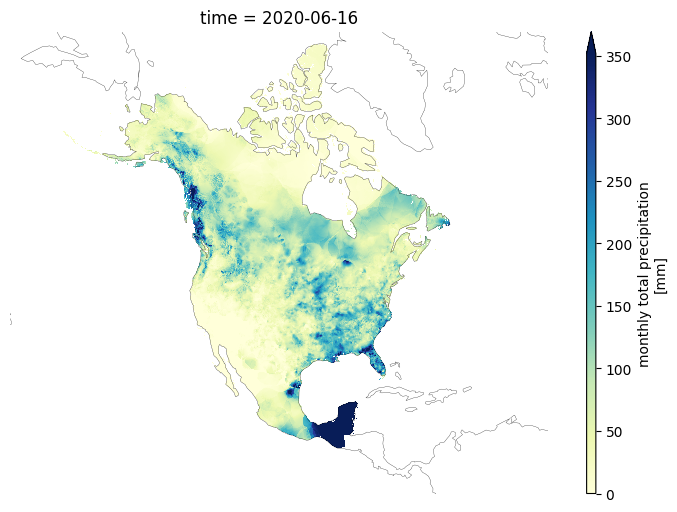

In [21]:
# Plot the average monthly precipitation for June 2020
#%%time

import cartopy.crs as ccrs

lcc = ds.variables["lambert_conformal_conic"].attrs

prj_kwargs = dict(
    central_latitude=lcc["latitude_of_projection_origin"],
    central_longitude=lcc["longitude_of_central_meridian"],
    standard_parallels=(lcc["standard_parallel"]),
)
crs = ccrs.LambertConformal(**prj_kwargs)

fig, ax = plt.subplots(
    figsize=(10, 6), dpi=100, subplot_kw=dict(projection=crs, frameon=False)
)
na_prcp.plot(
    ax=ax, transform=crs, cmap="YlGnBu", cbar_kwargs={"aspect": 50}, robust=True
)
ax.set_extent([-145, -58, 5, 84])
ax.coastlines(linewidth=0.2)
plt.show();


In [22]:
# Compute the top 6 years with large amounts of precipitation in the last 10 years
#%%time

total_avg_prcp = na["prcp"].isel(time=slice(-12 * 10, None)).mean(["x", "y"]).load()
df = total_avg_prcp.to_dataframe()
top6 = df.sort_values("prcp", ascending=False).head(6)
top6


KeyboardInterrupt: 

In [ ]:
# Years with large average amount of precipitation
top6


/tmp/ipykernel_2452/969498448.py:21: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


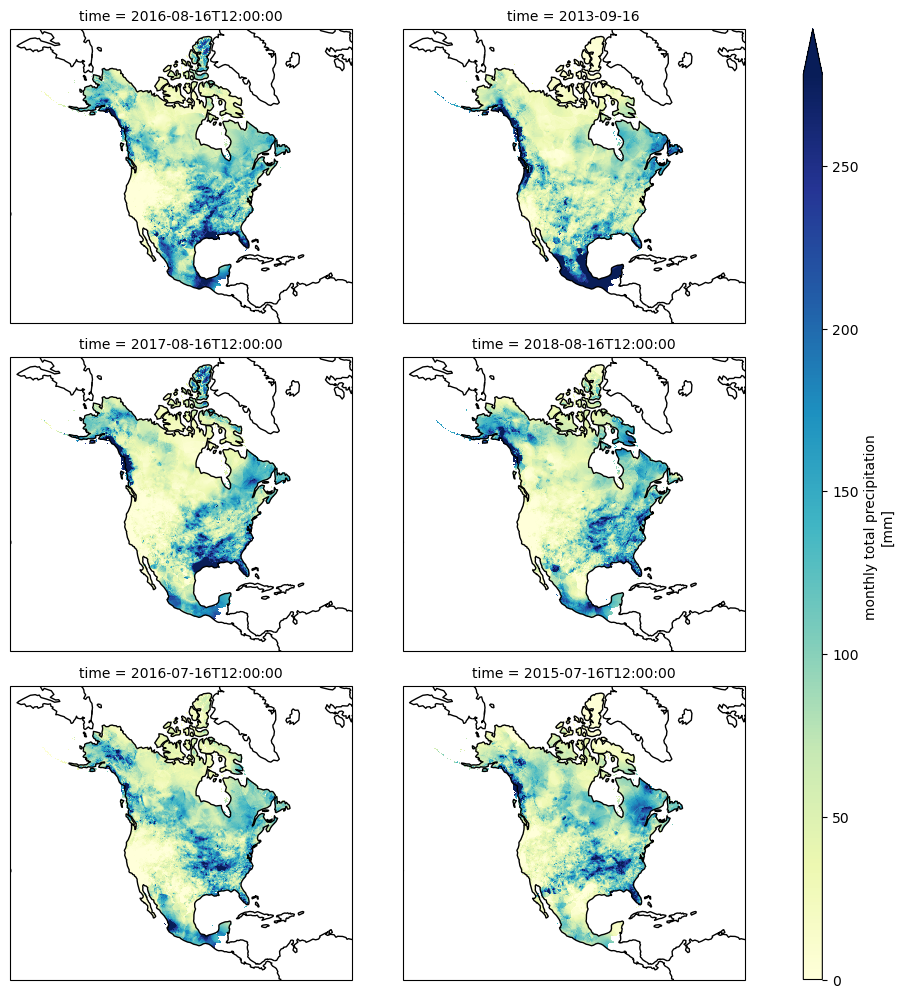

In [ ]:
# Create plots of these years
#%%time

wettest_months = top6.index.to_list()
da = (
    na["prcp"]
    .sel(time=wettest_months)
    .coarsen(dim={"x": 8, "y": 8}, boundary="trim")
    .mean()
)
p = da.plot(
    col="time",
    col_wrap=2,
    figsize=(12, 10),
    cmap="YlGnBu",
    robust=True,
    subplot_kws=dict(projection=crs),
    cbar_kwargs={"aspect": 50},
)

for ax in p.axes.flat:
    ax.set_extent([-145, -58, 5, 84])
    ax.coastlines()


## Geospatial Classification

Geospatial data classification assign groups of data to categories, or classes, for further processing.

In this example we show how to use [`xarray-spatial`](https://github.com/makepath/xarray-spatial), which a Python library that implements common raster analysis functions using the optimized machine code accelerator [`numba`](https://numba.pydata.org/).

For this example, we need to install beforehand the following Python libraries:
* `pystac_client` for searching the [STAC](https://stacindex.org/) [- Index](https://stacspec.org/en/) for [COG](https://www.cogeo.org/) files.
* `planetary_computer` for interacting with [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/docs/overview/about) platform.
* `rasterio` a Python library for reading and writing
raster dataset files used in [GIS](https://en.wikipedia.org/wiki/Geographic_information_system) like [GeoTIFF](https://en.wikipedia.org/wiki/GeoTIFF).
* `xarray-spatial` library described above.
* [`datashader`](https://datashader.org/)  graphics library for creating meaningful representations of large datasets quickly and flexibly.
* `rioxarray` is an extension of xarray.

The [`xarray`](https://docs.xarray.dev/en/stable/getting-started-guide/index.html) is a standard Python library for manipulating multidimensional arrays (sometimes called ["tensors"](https://en.wikipedia.org/wiki/Tensor))


This is a view of `xarray-spatial` library dependencies.

![Xarray-Spatial](https://raw.githubusercontent.com/makepath/xarray-spatial/master/img/dependencies.svg)

In [23]:
# Install pystac_client
!pip install pystac_client --quiet


In [24]:
# Install the planetary_computer library
!pip install planetary_computer --quiet


In [25]:
# Install the rasterio library
!pip install rasterio --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 16.9 MB/s eta 0:00:00


Import the required libraries for this example.

In [26]:
# Install datashader
!pip install datashader --quiet

# Will require restarting runtime (please do!)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 51.5 MB/s eta 0:00:00


In [2]:
!pip uninstall -y numpy
!pip install numpy==1.24.1

Found existing installation: numpy 1.23.4
Uninstalling numpy-1.23.4:
  Successfully uninstalled numpy-1.23.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 33.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-spatial 0.3.7 requires numpy<=1.23.4, but you have numpy 1.24.1 which is incompatible.


In [1]:
#!pip install xrspatial

!pip install xarray-spatial --quiet


In [2]:
# Install rioxarray
!pip install rioxarray --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.5 MB/s eta 0:00:00


## Getting started

All the required libraries and dependencies need to be loaded into the working memory.


In [3]:
from datashader.transfer_functions import shade
import datashader as ds
import matplotlib.pyplot as plt
from xrspatial.classify import natural_breaks

import pystac_client
import planetary_computer
import xarray as xr
import rasterio as rio
import rioxarray


We use `pystat_client` to search the _Cloud Optimized GeoTIFF_ in the [NASADEM Collection](https://planetarycomputer.microsoft.com/dataset/nasadem) of topographic data at 1 arc-second (~30m) covering the [Grand Canyon National Park](https://en.wikipedia.org/wiki/Grand_Canyon_National_Park) in the [STAC catalog](https://stacindex.org/catalogs) at Microsoft.

In [4]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)
point = {"type": "Point", "coordinates": [-112.107676, 36.101690]}
search = catalog.search(collections=["nasadem"], intersects=point, limit=1)
item = next(search.get_items())
item


/usr/local/lib/python3.10/dist-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


<Item id=NASADEM_HGT_n36w113>

We then use the [rioxarray.open_rasterio](https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html#rioxarray) function to open the remote COG image, [dropping](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.drop.html?highlight=drop#xarray.Dataset.drop) the "band" column and returning the [squeezed](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.squeeze.html) dataset.

Once we have the image in memory, we can use the [imgshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) from the [graphics library Matplotlib](https://matplotlib.org/stable/index.html) to show it.


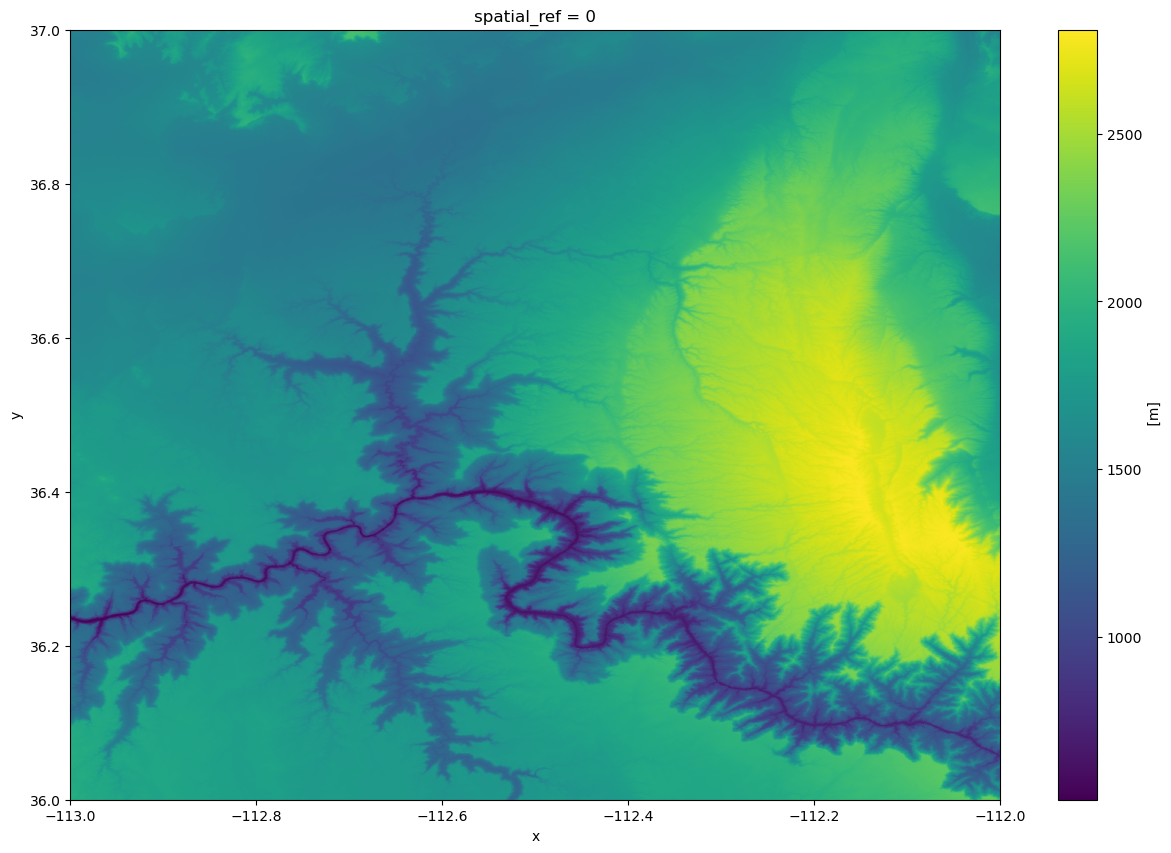

In [ ]:
# Remote file stored in "item" variable
url = planetary_computer.sign(item.assets["elevation"].href)

# open remote COG file
img_arr = rioxarray.open_rasterio(url).squeeze().drop("band")

# Show resulting raster image
img_arr.plot.imshow(figsize=(15, 10));


Next, we will use [xarray-spatial natural breaks classification](https://xarray-spatial.org/v0.2.7/reference/_autosummary/xrspatial.classify.natural_breaks.html) function using the [Jenks natural breaks optimization](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization).

We select a sample of 20,000 digital elevation data points and do a [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) using 15 classes (contour levels).

After that is done, the [shade](https://datashader.org/api.html?highlight=shade#datashader.transfer_functions.shade) function from `datashader`is used to color the classes.


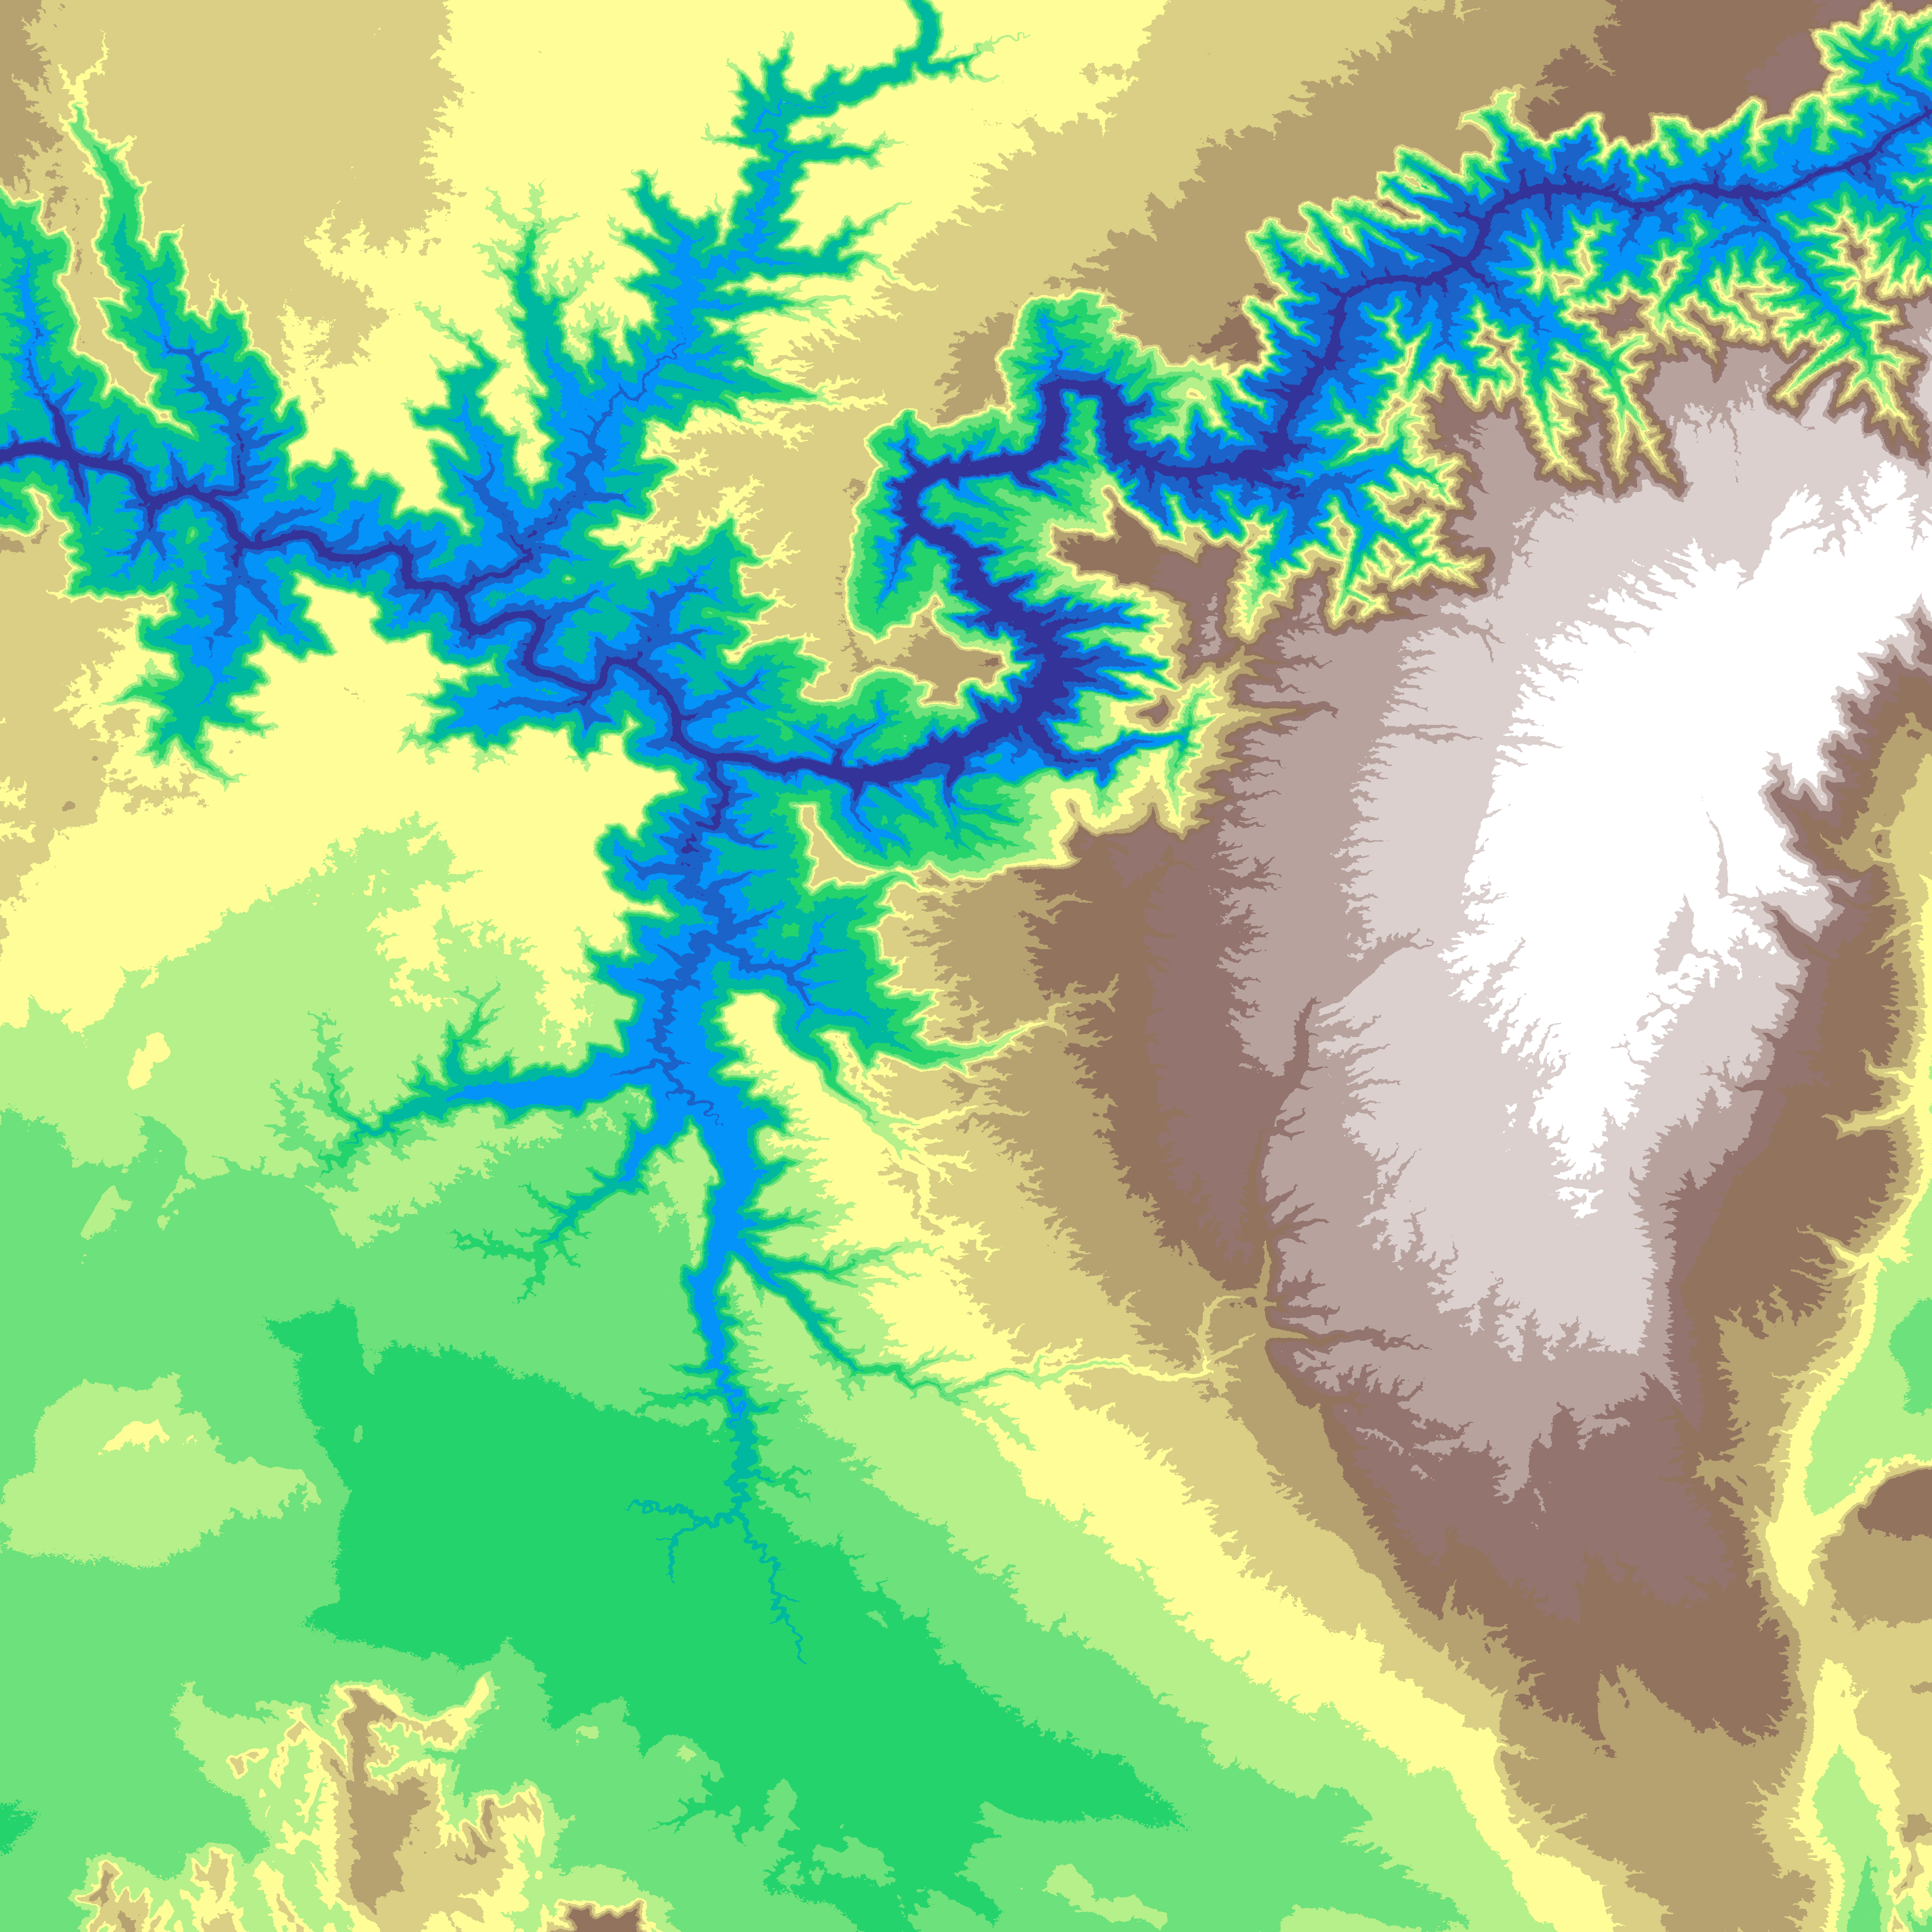

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]

# classify the image using natural breaks
natural_breaks_result = natural_breaks(img_arr, num_sample=20000, k=15)
#
shade(natural_breaks_result, cmap=plt.get_cmap("terrain"), how="linear")


Another way of classifying the elevation contour levels of the raster image,  is using the [xrspatial.classify.equal_intervals](https://xarray-spatial.org/v0.2.7/reference/_autosummary/xrspatial.classify.equal_interval.html#xrspatial.classify.equal_interval) function that used intervals of equal length.

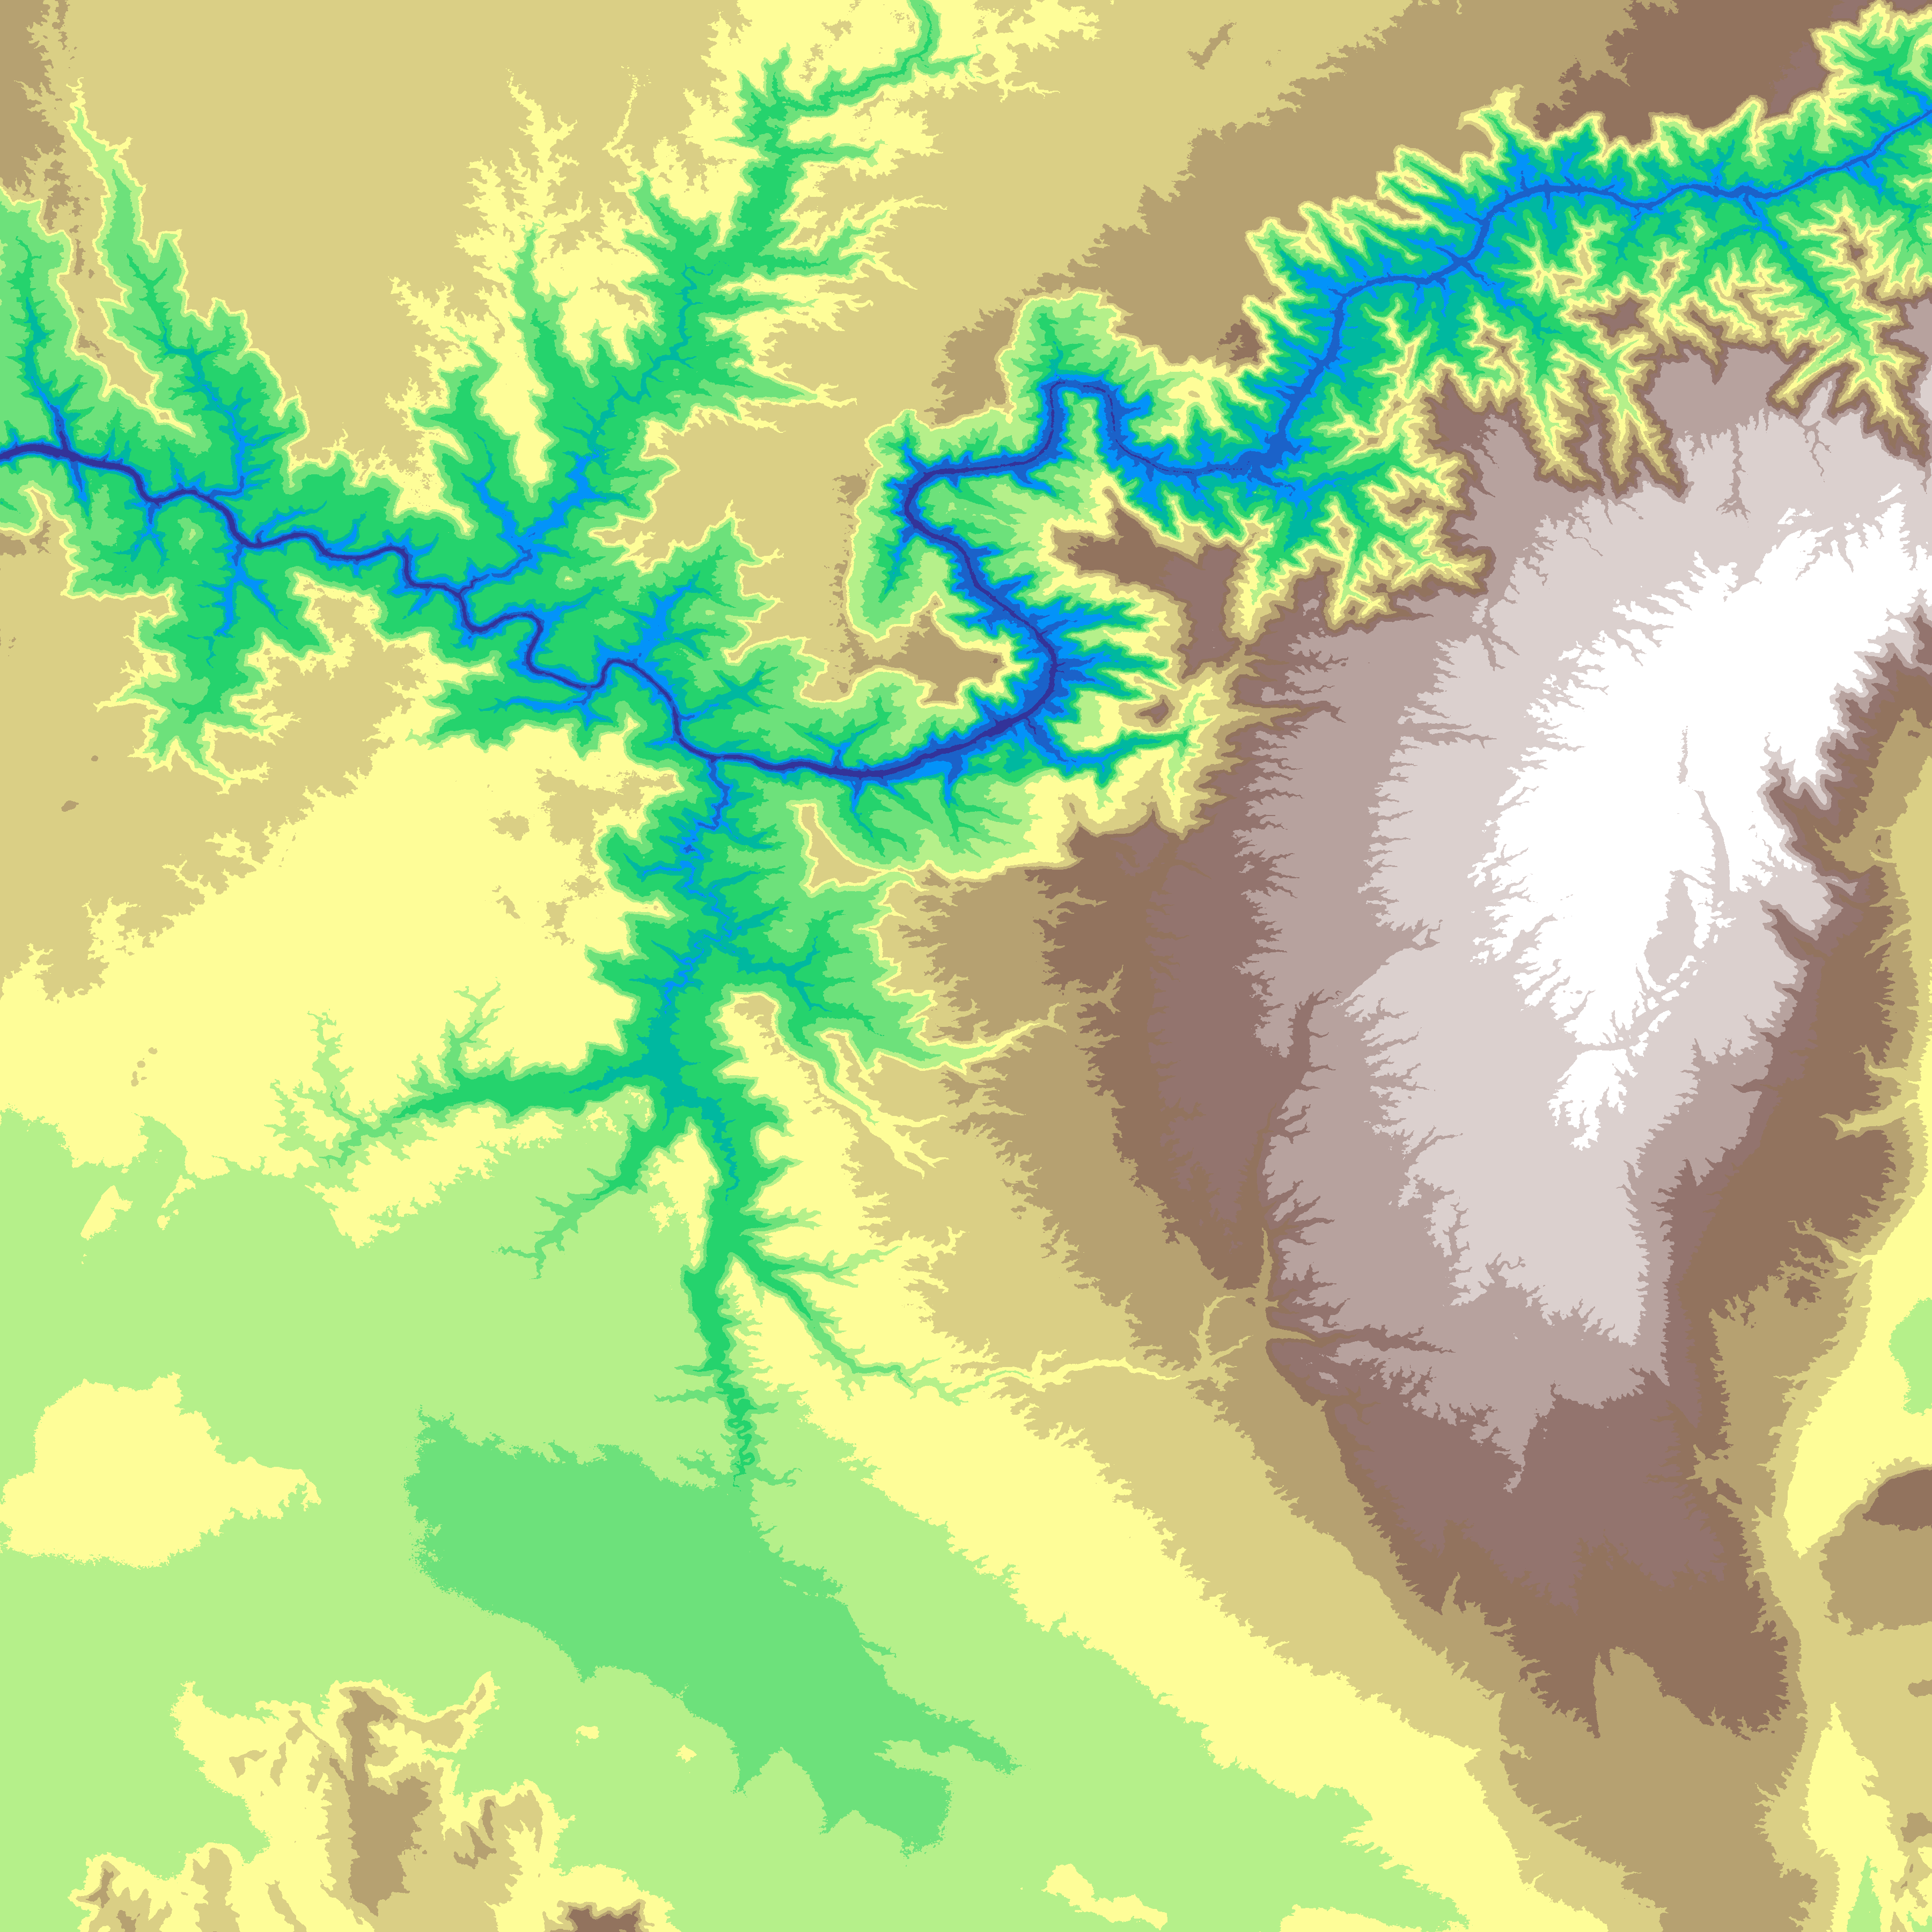

In [ ]:
from xrspatial.classify import equal_interval

equal_interval_result = equal_interval(img_arr, k=15)

shade(equal_interval_result, cmap=plt.get_cmap("terrain"), how="linear")
